<a href="https://colab.research.google.com/github/ChaitanyaHandore/B9AI101_NLP-main/blob/main/New_thesis_notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Business Understanding

**Project Title:** Automated Crop Disease Classification  
**Problem Statement:**  
I want to build a model that, given an image of a crop leaf, can accurately identify which disease (or healthy status) it shows. This will help farmers rapidly diagnose issues and take timely action.

**Objectives:**  
- Train a computer-vision model to classify leaf images into their correct disease category.  
- Achieve ≥ 85% validation accuracy across all classes.  
- Handle class imbalance so that rare diseases aren’t neglected.


---



# Setup & Imports

I configure CUDA launch blocking for easier debugging, install the core PyTorch, import all the libraries I’ll need, mount Google Drive, and unpack my dataset.

In [1]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
!pip install torch torchvision timm --quiet

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import models
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

print("✅ Libraries loaded.")
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.1 MB/s eta 0:00:00
✅ Libraries loaded.
Torch: 2.6.0+cu124
CUDA available: True


# Unzip Dataset & Inspect Folder Structure

I unzip `disease_data.zip` from Drive into `/content/data/` , then list out the top-level folders to confirm I have the expected `train/`, `val/`, and `test/` splits, and that each crop directory contains its disease subfolders.

In [5]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -q /content/drive/MyDrive/disease_data.zip -d /content/data/

Mounted at /content/drive


In [6]:
!unzip -q /content/drive/MyDrive/disease_data.zip -d /content/

In [7]:
# Verify the top-level folders
!ls /content/disease_data

test  train  val


In [8]:
# Inspect one split
!ls /content/data/disease_data/train

Cashew_anthracnose	  Cassava_healthy      Maize_streak_virus
Cashew_gumosis		  Cassava_mosaic       Tomato_healthy
Cashew_healthy		  Maize_fall_armyworm  Tomato_leaf_blight
Cashew_leaf_miner	  Maize_grasshoper     Tomato_leaf_curl
Cashew_red_rust		  Maize_healthy        Tomato_septoria_leaf_spot
Cassava_bacterial_blight  Maize_leaf_beetle    Tomato_verticulium_wilt
Cassava_brown_spot	  Maize_leaf_blight
Cassava_green_mite	  Maize_leaf_spot


#Step 2: Data Mining & Exploration


##2.1. Compute Class Distribution

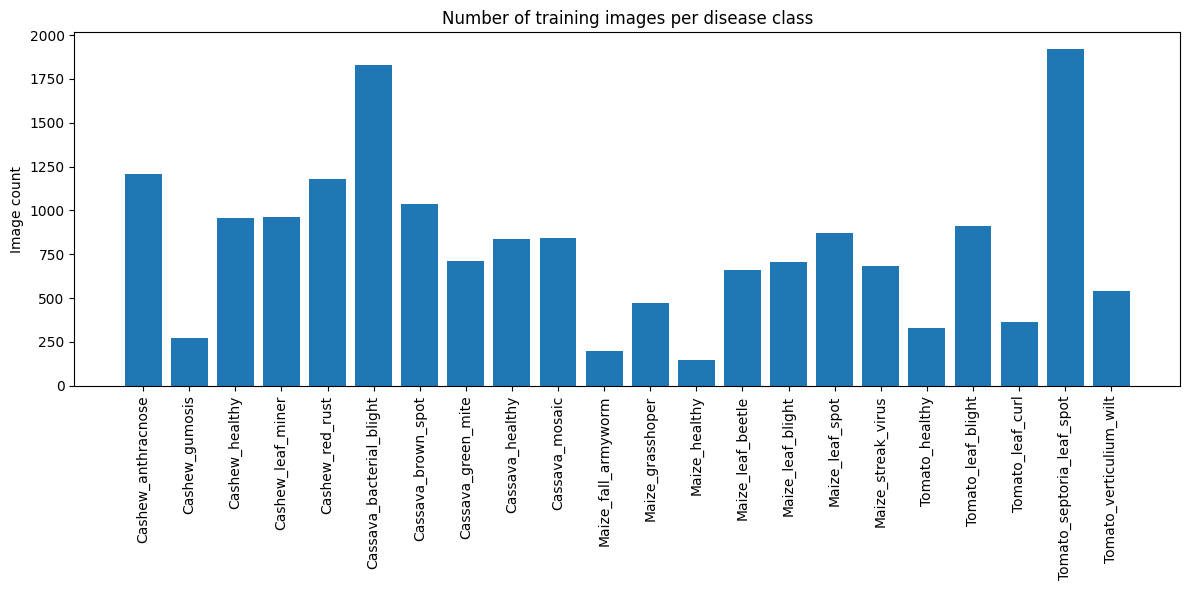

In [9]:
# 1) Imports
import os
import pandas as pd
import matplotlib.pyplot as plt

# 2) Point to your train directory
train_dir = "/content/data/disease_data/train"

# 3) Gather class names and counts
classes = sorted(os.listdir(train_dir))
counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in classes]

# 4) Create a DataFrame for easy viewing
df = pd.DataFrame({"disease": classes, "count": counts})
df

# 5) Plot the imbalance
plt.figure(figsize=(12,6))
plt.bar(df["disease"], df["count"])
plt.xticks(rotation=90)
plt.title("Number of training images per disease class")
plt.ylabel("Image count")
plt.tight_layout()
plt.show()

##2.2 Visualize random samples per class


In [10]:
# --- Cell: Setup paths and imports ---
import os, random
from PIL import Image
import matplotlib.pyplot as plt

# Adjust this if your dataset lives elsewhere
TRAIN_DIR = "/content/data/disease_data/train"

# Grab the class names
classes = sorted(os.listdir(TRAIN_DIR))
print(f"Found classes: {classes}")

# Quick sanity check
assert all(os.path.isdir(os.path.join(TRAIN_DIR, c)) for c in classes), "One of the class folders is missing!"

Found classes: ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf_miner', 'Cashew_red_rust', 'Cassava_bacterial_blight', 'Cassava_brown_spot', 'Cassava_green_mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall_armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf_beetle', 'Maize_leaf_blight', 'Maize_leaf_spot', 'Maize_streak_virus', 'Tomato_healthy', 'Tomato_leaf_blight', 'Tomato_leaf_curl', 'Tomato_septoria_leaf_spot', 'Tomato_verticulium_wilt']


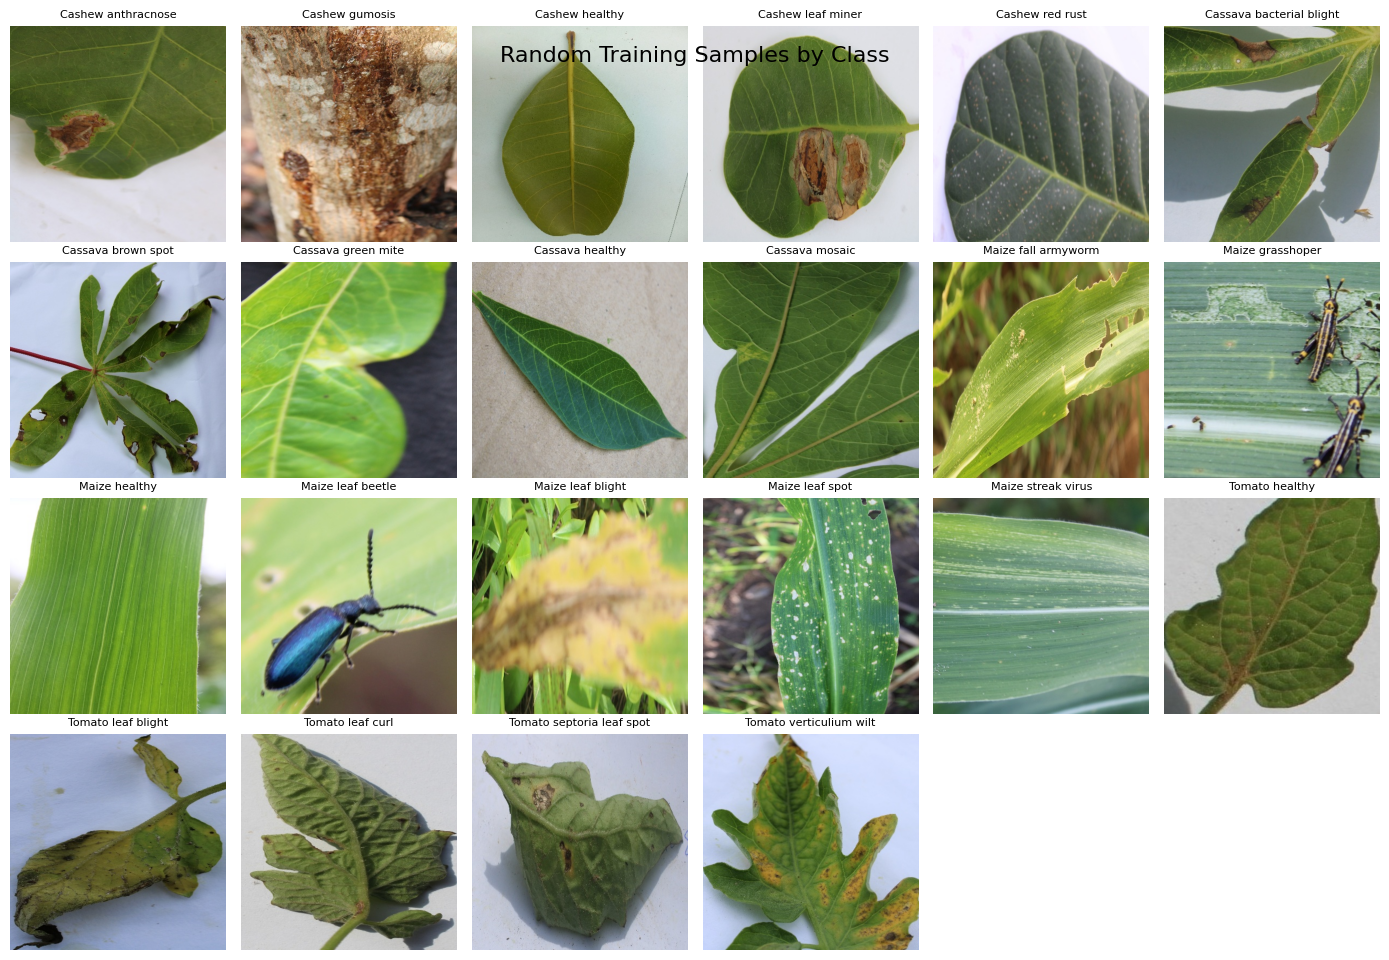

In [11]:
# --- Cell: Random sample from each class ---
import matplotlib.pyplot as plt
from PIL import Image
import random

plt.figure(figsize=(14, 10))
for i, cls in enumerate(classes):
    cls_dir = os.path.join(TRAIN_DIR, cls)
    # pick a random file (skip hidden files)
    fn = random.choice([f for f in os.listdir(cls_dir) if not f.startswith('.')])
    img = Image.open(os.path.join(cls_dir, fn)).convert("RGB")

    ax = plt.subplot(4, 6, i+1)       # 4 rows × 6 columns layout for 22 classes
    ax.imshow(img)
    ax.set_title(cls.replace('_', ' '), fontsize=8)
    ax.axis('off')

plt.suptitle("Random Training Samples by Class", fontsize=16, y=0.92)
plt.tight_layout()
plt.show()

## 2.3 Plot Image Size Distribution

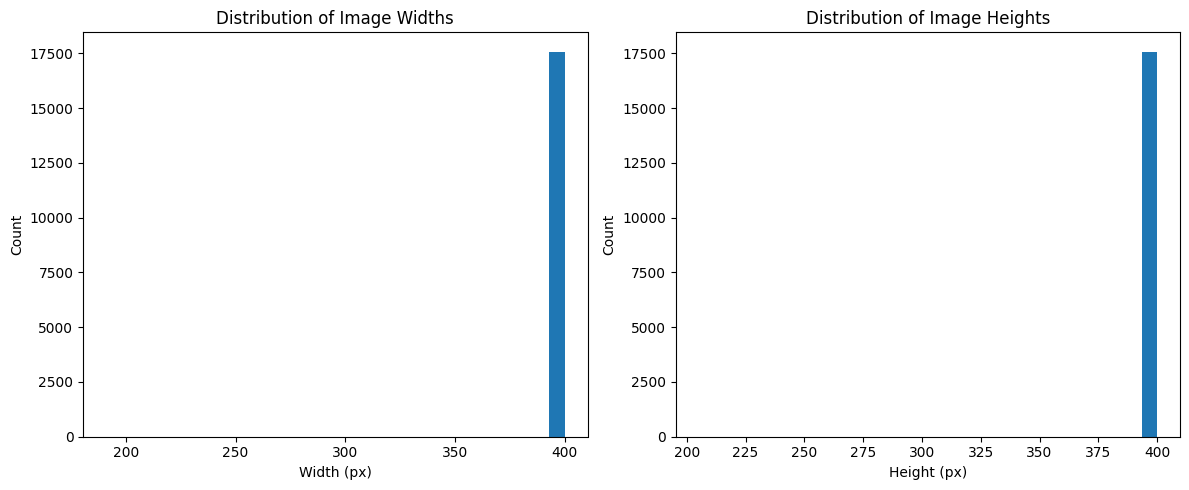

In [12]:
# --- Cell: Image width & height histograms ---
widths, heights = [], []
for cls in classes:
    cls_dir = os.path.join(TRAIN_DIR, cls)
    for fname in os.listdir(cls_dir):
        path = os.path.join(cls_dir, fname)
        try:
            w, h = Image.open(path).size
            widths.append(w)
            heights.append(h)
        except:
            continue   # skip any unreadable file

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(widths, bins=30)
plt.title("Distribution of Image Widths")
plt.xlabel("Width (px)")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(heights, bins=30)
plt.title("Distribution of Image Heights")
plt.xlabel("Height (px)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## 2.4: Compute & Visualize Class Imbalance, and prepare for weighted sampling.

Class         Count    Weight
Cashew_anthracnose      1210    0.437
Cashew_gumosis           274    1.932
Cashew_healthy           957    0.553
Cashew_leaf_miner        964    0.549
Cashew_red_rust         1177    0.450
Cassava_bacterial_blight  1829    0.289
Cassava_brown_spot      1036    0.511
Cassava_green_mite       710    0.746
Cassava_healthy          835    0.634
Cassava_mosaic           843    0.628
Maize_fall_armyworm      199    2.660
Maize_grasshoper         471    1.124
Maize_healthy            145    3.650
Maize_leaf_beetle        663    0.798
Maize_leaf_blight        704    0.752
Maize_leaf_spot          873    0.606
Maize_streak_virus       684    0.774
Tomato_healthy           329    1.609
Tomato_leaf_blight       910    0.582
Tomato_leaf_curl         362    1.462
Tomato_septoria_leaf_spot  1920    0.276
Tomato_verticulium_wilt   541    0.978


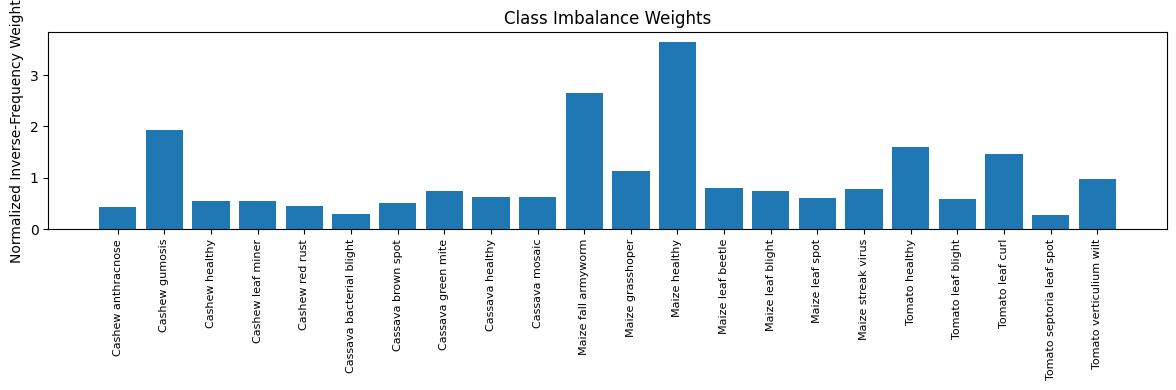

In [13]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# Path to your training directory
TRAIN_DIR = "/content/disease_data/train"

# 1. Count images per class
classes = sorted(os.listdir(TRAIN_DIR))
counts = Counter({cls: len(os.listdir(os.path.join(TRAIN_DIR, cls)))
                  for cls in classes})

total_images = sum(counts.values())

# 2. Compute frequencies and inverse frequencies
freqs = {cls: counts[cls] / total_images for cls in classes}
inv_freqs = {cls: 1.0 / freqs[cls] for cls in classes}

# 3. Normalize so mean weight = 1
mean_inv = sum(inv_freqs.values()) / len(inv_freqs)
class_weights = [inv_freqs[cls] / mean_inv for cls in classes]

# 4. Display
print("Class         Count    Weight")
for cls, cnt, w in zip(classes, counts.values(), class_weights):
    print(f"{cls:<22} {cnt:>5}    {w:.3f}")

# 5. Bar chart of weights
plt.figure(figsize=(12,4))
plt.bar(range(len(classes)), class_weights)
plt.xticks(range(len(classes)), [c.replace('_',' ') for c in classes],
           rotation=90, fontsize=8)
plt.ylabel("Normalized Inverse-Frequency Weight")
plt.title("Class Imbalance Weights")
plt.tight_layout()
plt.show()

#  Build WeightedRandomSampler & Dataloaders

We construct our PyTorch `ImageFolder` datasets, then apply the computed inverse-frequency weights to create a `WeightedRandomSampler` for the training loader. Validation and test loaders remain unweighted.

In [14]:
import os
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms

# 1. Paths
DATA_DIR   = "/content/disease_data"
TRAIN_DIR  = os.path.join(DATA_DIR, "train")
VAL_DIR    = os.path.join(DATA_DIR, "val")
TEST_DIR   = os.path.join(DATA_DIR, "test")

# 2. Image transforms
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),       # ConvNeXt expects 224×224
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# 3. Build the raw training dataset
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=eval_tf)
test_ds  = datasets.ImageFolder(TEST_DIR,  transform=eval_tf)

# 4. Prepare sample weights for each image in train_ds
#    Using the per-class normalized inverse-freq weights computed earlier:
class_weights_list = torch.tensor([
    0.437, 1.932, 0.553, 0.549, 0.450, 0.289, 0.511,
    0.746, 0.634, 0.628, 2.660, 1.124, 3.650, 0.798,
    0.752, 0.606, 0.774, 1.609, 0.582, 1.462, 0.276, 0.978
], dtype=torch.float)

# Map each sample to its class weight
sample_weights = [ class_weights_list[label] for _, label in train_ds.samples ]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# 5. Create DataLoaders
batch_size = 32

train_loader = DataLoader(
    train_ds, batch_size=batch_size,
    sampler=sampler, num_workers=2, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size,
    shuffle=False, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_ds, batch_size=batch_size,
    shuffle=False, num_workers=2, pin_memory=True
)

print(f"→ Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

→ Train batches: 552, Val batches: 118


# Clone Repo & Place Data

I clone my `crop_detection_thesis` repository, ensure its `src/` folder and scripts are present, then copy my unzipped `disease_data/` into the repo’s `data/` directory.

In [15]:
from google.colab import drive
drive.mount('/content/drive')
!git clone https://github.com/chaitanyahandore/crop_detection_thesis.git
%cd crop_detection_thesis

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'crop_detection_thesis'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 51 (delta 16), reused 24 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 25.66 KiB | 25.66 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/crop_detection_thesis


In [16]:
%cd /content/crop_detection_thesis

!ls

/content/crop_detection_thesis
requirements.txt  src


In [17]:
%cd /content/crop_detection_thesis

/content/crop_detection_thesis


# train_single_crop.py

## OLD MODELS (resnet50, vgg16, alexnet)

In [18]:
%matplotlib inline

In [19]:
!pip install torch torchvision timm --quiet

In [20]:
from IPython.display import Image, display

###resnet50

In [21]:
!python3 src/train_single_crop.py \
  --data_dir /content/data/disease_data \
  --crop Maize \
  --model resnet50 \
  --pretrained \
  --epochs 20 \
  --batch_size 32 \
  --lr 1e-4 \
  --weight_decay 1e-2 \
  --class_weights 1.796 0.759 2.465 0.539 0.508 0.409 0.523

→ `Maize` has 7 subclasses: ['fall_armyworm', 'grasshoper', 'healthy', 'leaf_beetle', 'leaf_blight', 'leaf_spot', 'streak_virus']
→ Building `resnet50`, pretrained=True
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100% 97.8M/97.8M [00:00<00:00, 234MB/s]
Epoch 1/20  Train 1.2059/0.5590  Val   0.5902/0.7651
Epoch 2/20  Train 0.5839/0.7609  Val   0.4957/0.8128
Epoch 3/20  Train 0.5101/0.7799  Val   0.4495/0.8241
Epoch 4/20  Train 0.4350/0.8085  Val   0.3768/0.8505
Epoch 5/20  Train 0.3951/0.8221  Val   0.4507/0.8405
Epoch 6/20  Train 0.3757/0.8254  Val   0.3688/0.8580
Epoch 7/20  Train 0.3515/0.8414  Val   0.3959/0.8518
Epoch 8/20  Train 0.3517/0.8320  Val   0.3740/0.8442
Epoch 9/20  Train 0.3399/0.8443  Val   0.4220/0.8492
Epoch 10/20  Train 0.3293/0.8476  Val   0.3773/0.8555
Epoch 11/20  Train 0.2946/0.8542  Val   0.3565/0.8631
Epoch 12/20  Train 0.2854/0.8628  Val   0.3676/0.8593
Epoch 13/20  Train 

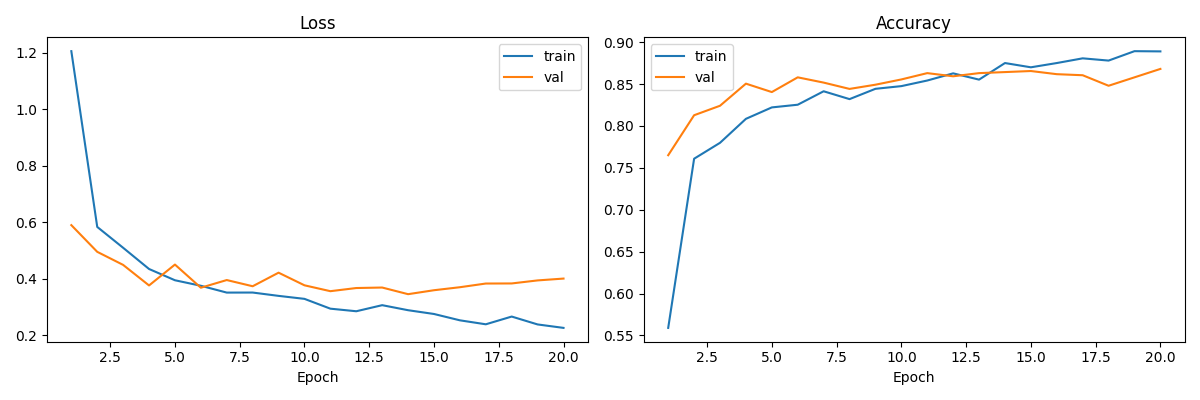

In [22]:
display(Image("training_curves_resnet50.png"))

###vgg16

In [23]:
!python src/train_single_crop.py \
  --data_dir /content/data/disease_data \
  --crop Maize \
  --model vgg16 \
  --pretrained \
  --epochs 20 \
  --batch_size 32 \
  --lr 1e-4 \
  --weight_decay 1e-2 \
  --class_weights 1.796 0.759 2.465 0.539 0.508 0.409 0.523

→ `Maize` has 7 subclasses: ['fall_armyworm', 'grasshoper', 'healthy', 'leaf_beetle', 'leaf_blight', 'leaf_spot', 'streak_virus']
→ Building `vgg16`, pretrained=True
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:02<00:00, 216MB/s]
Epoch 1/20  Train 1.1969/0.5419  Val   0.6973/0.7198
Epoch 2/20  Train 0.7788/0.6807  Val   0.5586/0.8065
Epoch 3/20  Train 0.6788/0.7248  Val   0.6384/0.7312
Epoch 4/20  Train 0.6152/0.7507  Val   0.5577/0.7877
Epoch 5/20  Train 0.6557/0.7422  Val   0.5517/0.7990
Epoch 6/20  Train 0.5795/0.7596  Val   0.5152/0.8216
Epoch 7/20  Train 0.5657/0.7671  Val   0.4647/0.8191
Epoch 8/20  Train 0.5191/0.7828  Val   0.5478/0.8015
Epoch 9/20  Train 0.4980/0.7965  Val   0.5033/0.8178
Epoch 10/20  Train 0.4645/0.7962  Val   0.4821/0.8241
Epoch 11/20  Train 0.4889/0.7850  Val   0.4986/0.8040
Epoch 12/20  Train 0.4730/0.7927  Val   0.4072/0.8379
Epoch 13/20  Train 0.4548/0.79

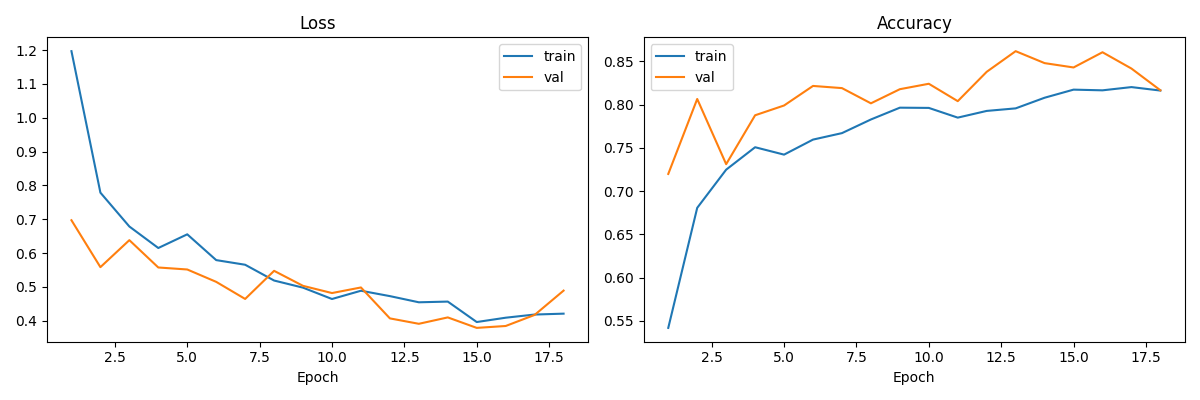

In [24]:
display(Image("training_curves_vgg16.png"))

###alexnet

In [25]:
!python src/train_single_crop.py \
  --data_dir /content/data/disease_data \
  --crop Maize \
  --model alexnet \
  --pretrained \
  --epochs 20 \
  --batch_size 32 \
  --lr 1e-4 \
  --weight_decay 1e-2 \
  --class_weights 1.796 0.759 2.465 0.539 0.508 0.409 0.523

→ `Maize` has 7 subclasses: ['fall_armyworm', 'grasshoper', 'healthy', 'leaf_beetle', 'leaf_blight', 'leaf_spot', 'streak_virus']
→ Building `alexnet`, pretrained=True
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100% 233M/233M [00:01<00:00, 236MB/s]
Epoch 1/20  Train 1.0982/0.5758  Val   0.7117/0.7450
Epoch 2/20  Train 0.7779/0.6930  Val   0.5440/0.7902
Epoch 3/20  Train 0.6939/0.7178  Val   0.5292/0.8015
Epoch 4/20  Train 0.6497/0.7291  Val   0.5047/0.7952
Epoch 5/20  Train 0.6004/0.7416  Val   0.5135/0.7940
Epoch 6/20  Train 0.5874/0.7457  Val   0.5159/0.7902
Epoch 7/20  Train 0.5133/0.7767  Val   0.5164/0.8065
Epoch 8/20  Train 0.5328/0.7668  Val   0.5541/0.7915
Epoch 9/20  Train 0.5243/0.7828  Val   0.4527/0.8141
Epoch 10/20  Train 0.5170/0.7751  Val   0.5065/0.8053
Epoch 11/20  Train 0.4971/0.7941  Val   0.4469/0.8116
Epoch 12/20  Train 0.4947/0.7844  Val   0.4328/0.8204
Epoch 13/20  Tra

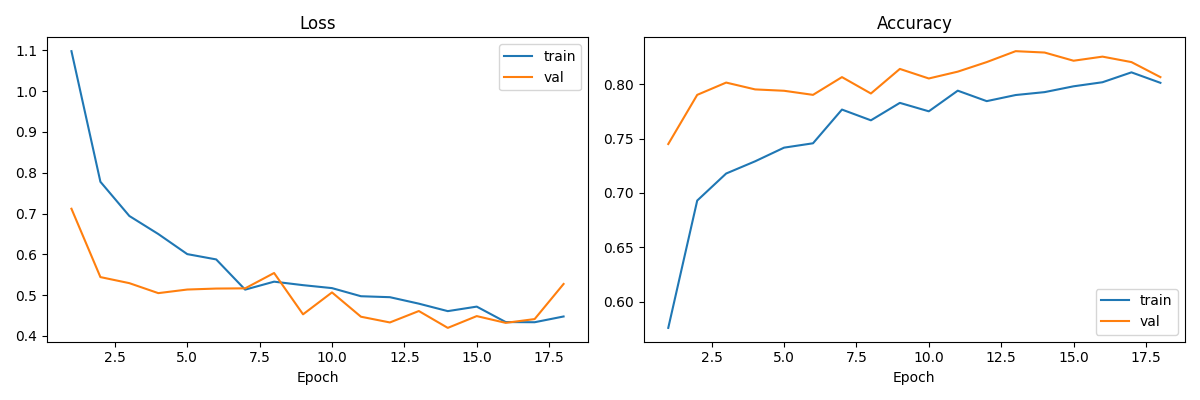

In [26]:
display(Image("training_curves_alexnet.png"))

## NEW MODELS (convnext_tiny, vit_b_16, mobilevit_s)

###convnext_tiny

In [27]:
!python src/train_single_crop.py \
  --data_dir /content/data/disease_data \
  --crop Maize \
  --model convnext_tiny \
  --pretrained \
  --epochs 20 \
  --batch_size 32 \
  --lr 1e-4 \
  --weight_decay 1e-2 \
  --class_weights 1.796 0.759 2.465 0.539 0.508 0.409 0.523

→ `Maize` has 7 subclasses: ['fall_armyworm', 'grasshoper', 'healthy', 'leaf_beetle', 'leaf_blight', 'leaf_spot', 'streak_virus']
→ Building `convnext_tiny`, pretrained=True
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100% 109M/109M [00:00<00:00, 234MB/s] 
Epoch 1/20  Train 0.8646/0.6756  Val   0.4479/0.8254
Epoch 2/20  Train 0.4681/0.7882  Val   0.3833/0.8455
Epoch 3/20  Train 0.3990/0.8184  Val   0.3646/0.8530
Epoch 4/20  Train 0.3919/0.8213  Val   0.4002/0.8681
Epoch 5/20  Train 0.3578/0.8310  Val   0.3466/0.8618
Epoch 6/20  Train 0.3272/0.8462  Val   0.3456/0.8643
Epoch 7/20  Train 0.2967/0.8572  Val   0.3148/0.8681
Epoch 8/20  Train 0.2712/0.8684  Val   0.3458/0.8606
Epoch 9/20  Train 0.2703/0.8657  Val   0.3327/0.8693
Epoch 10/20  Train 0.2862/0.8681  Val   0.3161/0.8744
Epoch 11/20  Train 0.2639/0.8823  Val   0.2995/0.8744
Epoch 12/20  Train 0.2605/0.8791  Val   0.3179/0.8643
Epoch

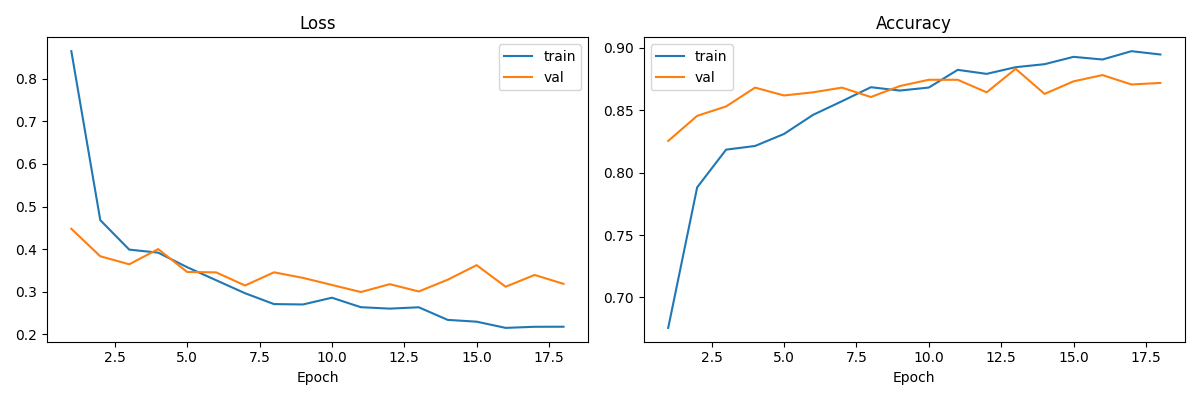

In [28]:
display(Image("training_curves_convnext_tiny.png"))

###vit_b_16

In [29]:
!python src/train_single_crop.py \
  --data_dir /content/data/disease_data \
  --crop Maize \
  --model vit_b_16 \
  --pretrained \
  --epochs 20 \
  --batch_size 32 \
  --lr 1e-4 \
  --weight_decay 1e-2 \
  --class_weights 1.796 0.759 2.465 0.539 0.508 0.409 0.523

→ `Maize` has 7 subclasses: ['fall_armyworm', 'grasshoper', 'healthy', 'leaf_beetle', 'leaf_blight', 'leaf_spot', 'streak_virus']
→ Building `vit_b_16`, pretrained=True
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100% 330M/330M [00:01<00:00, 210MB/s]
Epoch 1/20  Train 0.8078/0.6807  Val   0.5825/0.7638
Epoch 2/20  Train 0.5030/0.7756  Val   0.4219/0.8342
Epoch 3/20  Train 0.4601/0.7930  Val   0.4255/0.8317
Epoch 4/20  Train 0.4301/0.8029  Val   0.4218/0.8317
Epoch 5/20  Train 0.3957/0.8160  Val   0.4286/0.8379
Epoch 6/20  Train 0.3781/0.8248  Val   0.4101/0.8480
Epoch 7/20  Train 0.4025/0.8248  Val   0.3883/0.8405
Epoch 8/20  Train 0.3574/0.8387  Val   0.3549/0.8530
Epoch 9/20  Train 0.3646/0.8286  Val   0.3565/0.8668
Epoch 10/20  Train 0.3200/0.8534  Val   0.3916/0.8543
Epoch 11/20  Train 0.3123/0.8529  Val   0.3442/0.8681
Epoch 12/20  Train 0.3043/0.8540  Val   0.4859/0.8417
Epoch 13/20  Train 0.

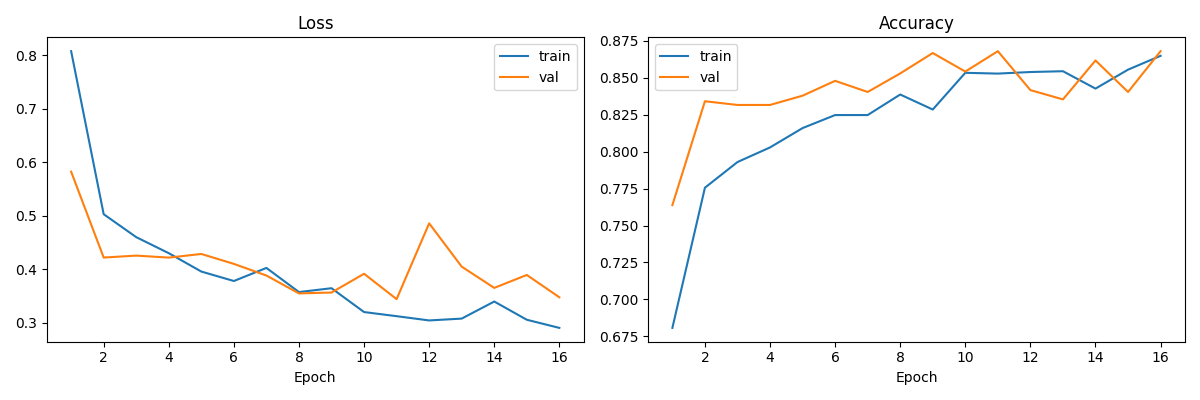

In [30]:
display(Image("training_curves_vit_b_16.png"))

###mobilevit_s

In [31]:
!python src/train_single_crop.py \
  --data_dir /content/data/disease_data \
  --crop Maize \
  --model mobilevit_s \
  --pretrained \
  --epochs 20 \
  --batch_size 32 \
  --lr 1e-4 \
  --weight_decay 1e-2 \
  --class_weights 1.796 0.759 2.465 0.539 0.508 0.409 0.523

→ `Maize` has 7 subclasses: ['fall_armyworm', 'grasshoper', 'healthy', 'leaf_beetle', 'leaf_blight', 'leaf_spot', 'streak_virus']
→ Building `mobilevit_s`, pretrained=True
model.safetensors: 100% 22.4M/22.4M [00:00<00:00, 183MB/s]
Epoch 1/20  Train 1.6434/0.4694  Val   1.1924/0.7362
Epoch 2/20  Train 0.9224/0.6737  Val   0.6775/0.7877
Epoch 3/20  Train 0.6327/0.7585  Val   0.5327/0.8191
Epoch 4/20  Train 0.5224/0.7855  Val   0.4601/0.8379
Epoch 5/20  Train 0.5105/0.7879  Val   0.4222/0.8430
Epoch 6/20  Train 0.4605/0.8024  Val   0.4236/0.8467
Epoch 7/20  Train 0.4326/0.8205  Val   0.3873/0.8518
Epoch 8/20  Train 0.4092/0.8213  Val   0.3817/0.8618
Epoch 9/20  Train 0.3736/0.8342  Val   0.3746/0.8668
Epoch 10/20  Train 0.3944/0.8363  Val   0.3709/0.8606
Epoch 11/20  Train 0.3935/0.8334  Val   0.3680/0.8606
Epoch 12/20  Train 0.3713/0.8379  Val   0.3780/0.8518
Epoch 13/20  Train 0.3470/0.8443  Val   0.3609/0.8731
Epoch 14/20  Train 0.3260/0.8540  Val   0.3583/0.8731
Epoch 15/20  Train 0.3

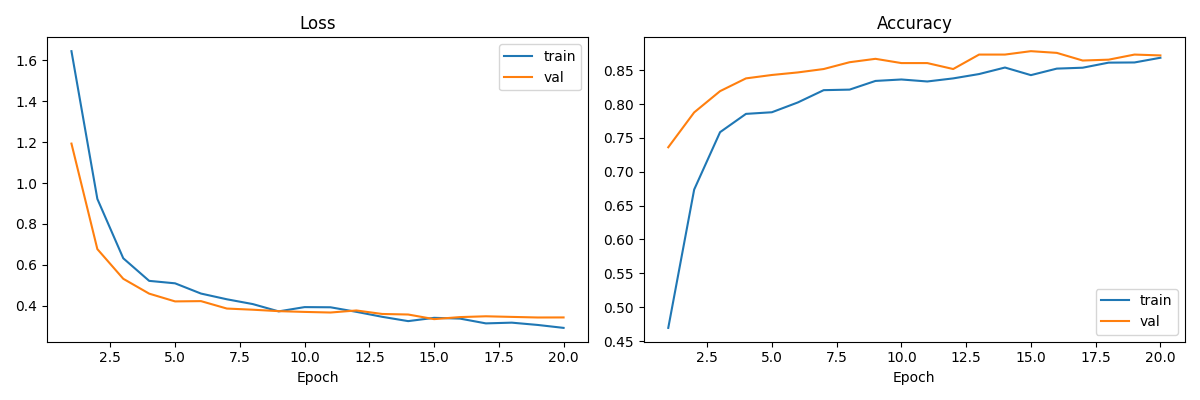

In [32]:
display(Image("training_curves_mobilevit_s.png"))

## Evaluation

In [33]:
# move into your repo root
%cd /content/crop_detection_thesis

/content/crop_detection_thesis


In [34]:
%%bash
cat > eval_all_models.py << 'EOF'
#!/usr/bin/env python3
import torch, numpy as np, timm
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms, models
from torch.utils.data import DataLoader
from train_single_crop import SingleCropDataset
import seaborn as sns, matplotlib.pyplot as plt, torch.nn as nn

# 1) Test‐time transforms
test_tf = transforms.Compose([
  transforms.Resize(256), transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# 2) DataLoader
DATA_DIR = "data/disease_data"
CROP     = "Maize"
test_ds  = SingleCropDataset(DATA_DIR, CROP, "test", transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
classes = test_ds.idx_to_class
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# helper to evaluate any model
def eval_model(name, build_fn, ckpt):
    print(f"\n=== {name} ===")
    model = build_fn().to(device).eval()
    model.load_state_dict(torch.load(ckpt, map_location="cpu"))
    all_p, all_t = [], []
    with torch.no_grad():
      for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_p.append(preds); all_t.append(labels.numpy())
    y_pred = np.concatenate(all_p); y_true = np.concatenate(all_t)
    print(f"Acc: {(y_pred==y_true).mean():.4f}")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis",
                xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion – {name}")
    plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"confusion_{name}.png")
    plt.show()

# 3) build functions + checkpoints for each model:
eval_model(
  "ConvNeXt-Tiny",
  lambda: (lambda m=models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT):
           (setattr(m.classifier[2], 'in_features', m.classifier[2].in_features) or m)
           or setattr(m.classifier[2], 'out_features', len(classes)) or m
          )(),
  "best_convnext_tiny.pth"
)
# repeat for Vit, MobileViT, ResNet50, VGG16, AlexNet…
# e.g.:
eval_model(
  "ResNet-50",
  lambda: (lambda m=models.resnet50(weights=models.ResNet50_Weights.DEFAULT):
           setattr(m.fc, 'out_features', len(classes)) or m)(),
  "best_resnet50.pth"
)
# …and so on for your six models
EOF

# confirm file is there
ls

best_alexnet.pth
best_convnext_tiny.pth
best_mobilevit_s.pth
best_resnet50.pth
best_vgg16.pth
best_vit_b_16.pth
eval_all_models.py
requirements.txt
src
training_curves_alexnet.png
training_curves_convnext_tiny.png
training_curves_mobilevit_s.png
training_curves_resnet50.png
training_curves_vgg16.png
training_curves_vit_b_16.png


In [61]:
%cd /content/crop_detection_thesis
!python3 -m src.eval_all_models

/content/crop_detection_thesis
→ Loaded test set: 809 images, 7 classes


=== Evaluating alexnet ===
Accuracy: 0.8047

               precision    recall  f1-score   support

fall_armyworm     0.8824    0.6818    0.7692        44
   grasshoper     0.8293    1.0000    0.9067       102
      healthy     0.7561    0.9688    0.8493        32
  leaf_beetle     0.9847    0.9021    0.9416       143
  leaf_blight     0.6897    0.7895    0.7362       152
    leaf_spot     0.7857    0.5820    0.6687       189
 streak_virus     0.7771    0.8776    0.8243       147

     accuracy                         0.8047       809
    macro avg     0.8150    0.8288    0.8137       809
 weighted avg     0.8109    0.8047    0.8005       809

→ saved confusion matrix to cm_alexnet.png


=== Evaluating convnext_tiny ===
Accuracy: 0.8455

               precision    recall  f1-score   support

fall_armyworm     0.9750    0.8864    0.9286        44
   grasshoper     0.9706    0.9706    0.9706       102
      healt

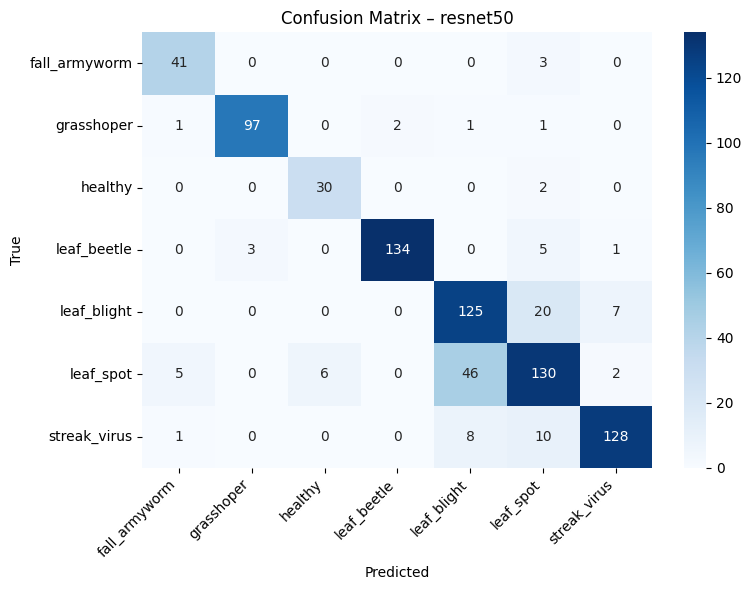

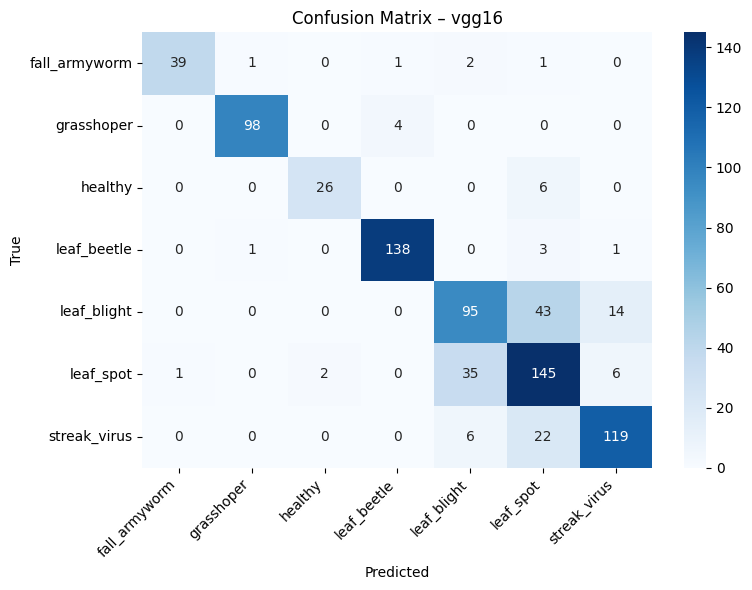

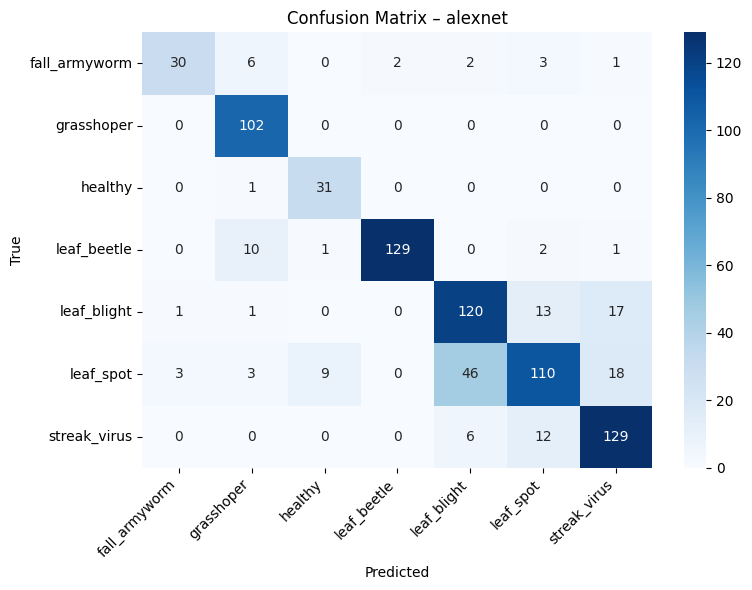

In [62]:
# Old models
display(Image("cm_resnet50.png"))
display(Image("cm_vgg16.png"))
display(Image("cm_alexnet.png"))

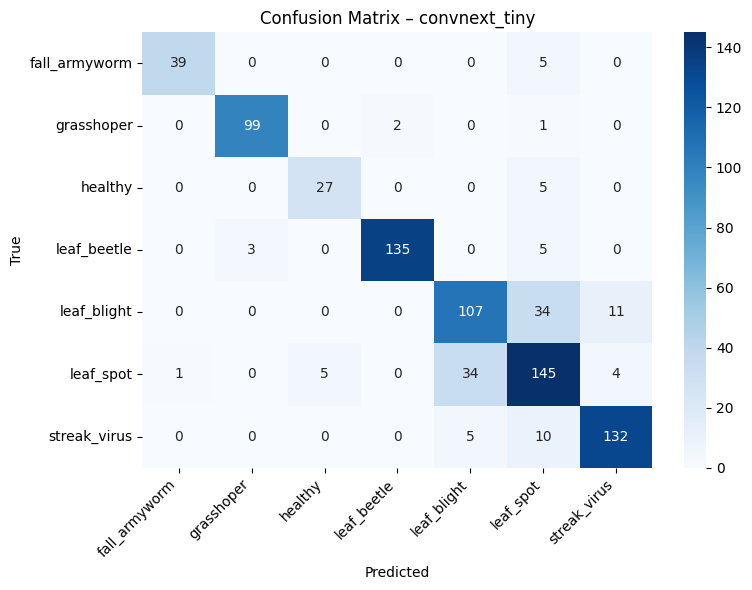

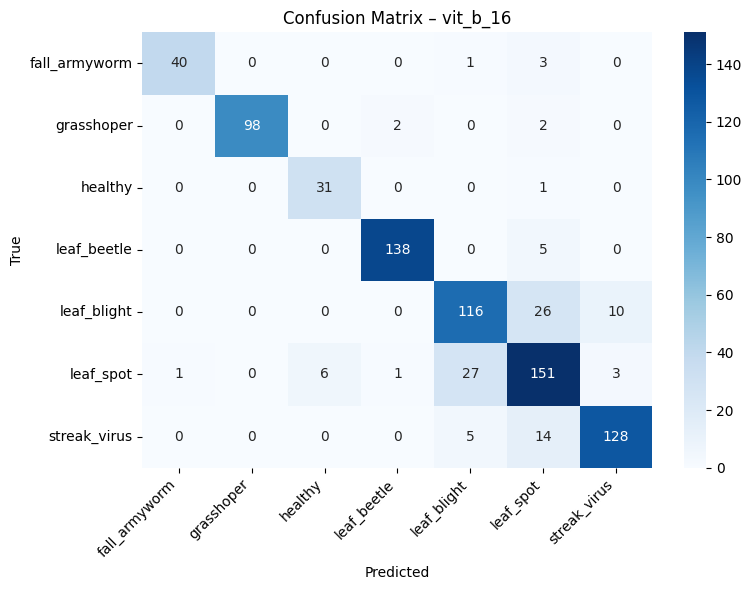

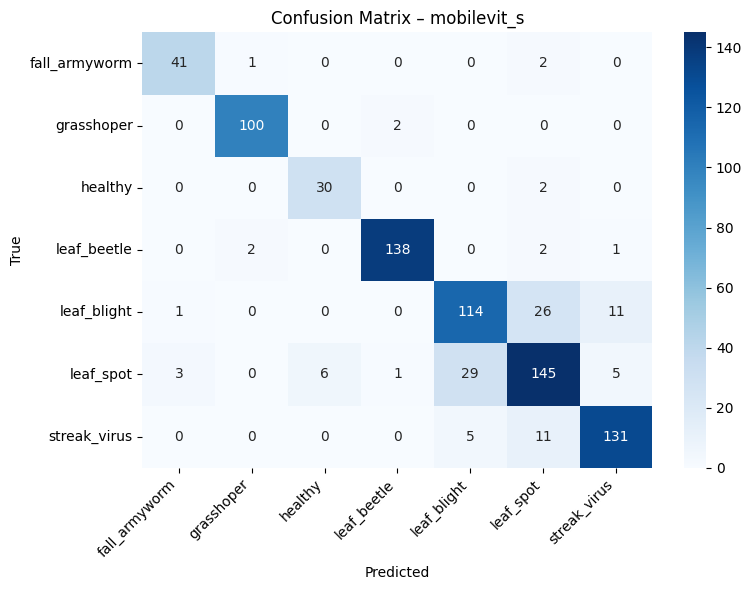

In [63]:
# New models
display(Image("cm_convnext_tiny.png"))
display(Image("cm_vit_b_16.png"))
display(Image("cm_mobilevit_s.png"))

# train_all_crop.py

In [38]:
%%bash
# Create a cleaning script
mkdir -p scripts

cat > scripts/clean_dataset.py << 'EOF'
#!/usr/bin/env python3
import os
from PIL import Image, UnidentifiedImageError

# Point this at your unzipped data folder
DATA_ROOT = os.path.join(os.path.dirname(__file__), '..', 'data', 'disease_data')

def clean(split_folder):
    removed = 0
    for subdir, _, files in os.walk(split_folder):
        for f in files:
            path = os.path.join(subdir, f)
            try:
                # try opening & verifying the image
                with Image.open(path) as img:
                    img.verify()
            except (UnidentifiedImageError, OSError):
                echo_path = path.replace(DATA_ROOT, '...')
                print(f"→ Removing corrupt image: {echo_path}")
                os.remove(path)
                removed += 1
    print(f"Cleaned {os.path.basename(split_folder)}: removed {removed} files.")

if __name__ == "__main__":
    for split in ("train","val","test"):
        folder = os.path.join(DATA_ROOT, split)
        print(f"\nCleaning split: {split}")
        clean(folder)
    print("\nAll done!")
EOF

# Make it executable
chmod +x scripts/clean_dataset.py

# Install pillow if needed
pip install --quiet pillow

# Run the cleaner
python3 scripts/clean_dataset.py


Cleaning split: train
Cleaned train: removed 0 files.

Cleaning split: val
Cleaned val: removed 0 files.

Cleaning split: test
Cleaned test: removed 0 files.

All done!


## OLD MODELS (resnet50, vgg16, alexnet)

###ResNet-50

In [39]:
# ResNet-50
!python3 src/train_all_crops.py \
  --data_dir /content/data/disease_data \
  --model resnet50 \
  --epochs 20 \
  --batch_size 32 \
  --lr 1e-4 \
  --weight_decay 1e-2 \
  --pretrained

→ Classes (22): ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf_miner', 'Cashew_red_rust', 'Cassava_bacterial_blight', 'Cassava_brown_spot', 'Cassava_green_mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall_armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf_beetle', 'Maize_leaf_blight', 'Maize_leaf_spot', 'Maize_streak_virus', 'Tomato_healthy', 'Tomato_leaf_blight', 'Tomato_leaf_curl', 'Tomato_septoria_leaf_spot', 'Tomato_verticulium_wilt']
Epoch 1/20  Train 1.0164/0.5839  Val   0.7128/0.7208
Epoch 2/20  Train 0.4691/0.7637  Val   0.5876/0.7715
Epoch 3/20  Train 0.4001/0.7934  Val   0.5504/0.7885
Epoch 4/20  Train 0.3459/0.8209  Val   0.4959/0.8079
Epoch 5/20  Train 0.3404/0.8238  Val   0.4658/0.8248
Epoch 6/20  Train 0.3189/0.8329  Val   0.4316/0.8365
Epoch 7/20  Train 0.2976/0.8410  Val   0.4908/0.8227
Epoch 8/20  Train 0.2876/0.8468  Val   0.4538/0.8301
Epoch 9/20  Train 0.2847/0.8471  Val   0.4743/0.8248
Epoch 10/20  Train 0.2693/0.8544  Val   

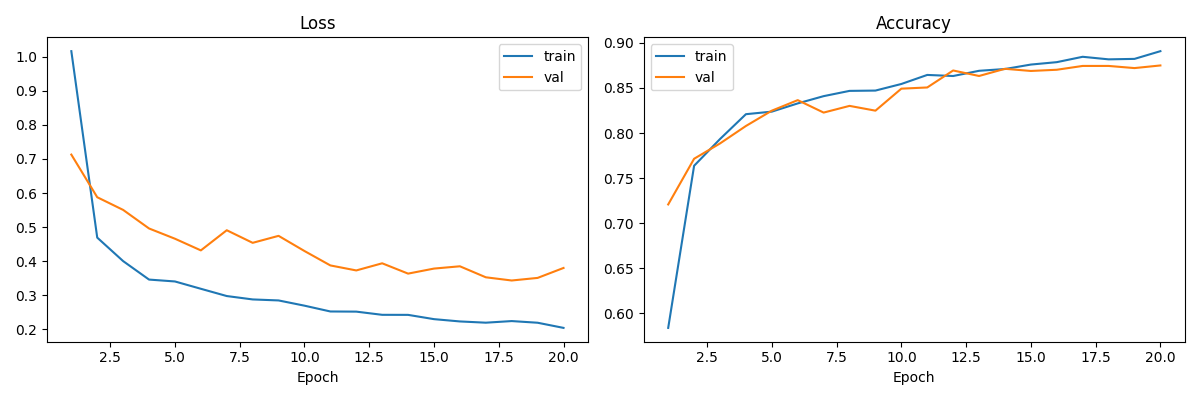

In [40]:
display(Image("resnet50_loss_acc.png"))

### vgg16

In [41]:
# vgg16
!python3 src/train_all_crops.py \
  --data_dir /content/data/disease_data \
  --model vgg16 \
  --epochs 20 \
  --batch_size 32 \
  --lr 1e-4 \
  --weight_decay 1e-2 \
  --pretrained

→ Classes (22): ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf_miner', 'Cashew_red_rust', 'Cassava_bacterial_blight', 'Cassava_brown_spot', 'Cassava_green_mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall_armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf_beetle', 'Maize_leaf_blight', 'Maize_leaf_spot', 'Maize_streak_virus', 'Tomato_healthy', 'Tomato_leaf_blight', 'Tomato_leaf_curl', 'Tomato_septoria_leaf_spot', 'Tomato_verticulium_wilt']
Epoch 1/20  Train 1.2961/0.4661  Val   1.0542/0.6001
Epoch 2/20  Train 0.7683/0.6535  Val   0.9444/0.6372
Epoch 3/20  Train 0.6171/0.7044  Val   0.7815/0.7189
Epoch 4/20  Train 0.5968/0.7141  Val   0.6761/0.7301
Epoch 5/20  Train 0.5197/0.7403  Val   0.6547/0.7436
Epoch 6/20  Train 0.5094/0.7501  Val   0.8276/0.6860
Epoch 7/20  Train 0.4942/0.7558  Val   0.6347/0.7314
Epoch 8/20  Train 0.4539/0.7750  Val   0.6612/0.7535
Epoch 9/20  Train 0.4664/0.7704  Val   0.6108/0.7588
Epoch 10/20  Train 0.4426/0.7778  Val   

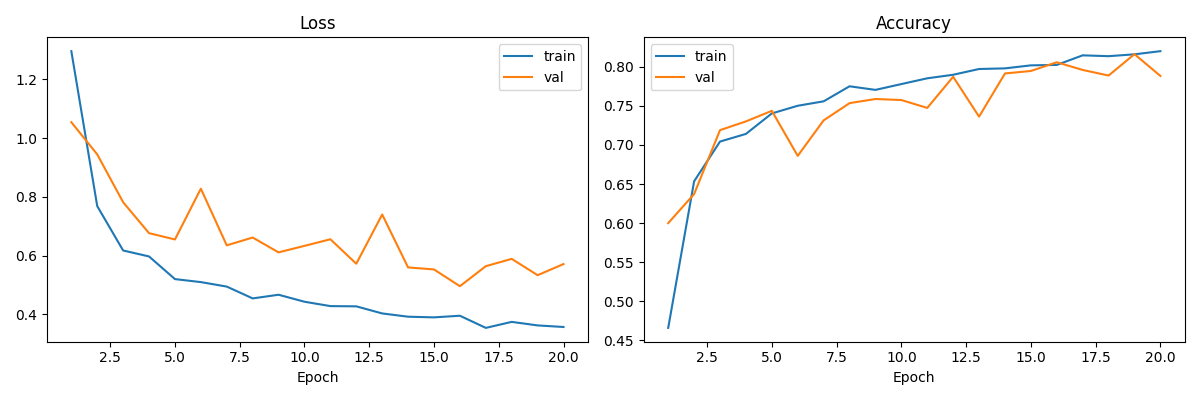

In [42]:
display(Image("vgg16_loss_acc.png"))

###alexnet

In [43]:
# alexnet
!python3 src/train_all_crops.py \
  --data_dir /content/data/disease_data \
  --model alexnet \
  --epochs 20 \
  --batch_size 32 \
  --lr 1e-4 \
  --weight_decay 1e-2 \
  --pretrained

→ Classes (22): ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf_miner', 'Cashew_red_rust', 'Cassava_bacterial_blight', 'Cassava_brown_spot', 'Cassava_green_mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall_armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf_beetle', 'Maize_leaf_blight', 'Maize_leaf_spot', 'Maize_streak_virus', 'Tomato_healthy', 'Tomato_leaf_blight', 'Tomato_leaf_curl', 'Tomato_septoria_leaf_spot', 'Tomato_verticulium_wilt']
Epoch 1/20  Train 1.2180/0.5028  Val   1.1387/0.6014
Epoch 2/20  Train 0.8013/0.6326  Val   0.8980/0.6680
Epoch 3/20  Train 0.7082/0.6639  Val   0.8417/0.7006
Epoch 4/20  Train 0.6661/0.6877  Val   0.8192/0.7022
Epoch 5/20  Train 0.6257/0.7040  Val   0.7715/0.7065
Epoch 6/20  Train 0.6100/0.7084  Val   0.8620/0.6990
Epoch 7/20  Train 0.5659/0.7209  Val   0.7029/0.7367
Epoch 8/20  Train 0.5488/0.7298  Val   0.6416/0.7577
Epoch 9/20  Train 0.5579/0.7287  Val   0.8124/0.7205
Epoch 10/20  Train 0.5290/0.7395  Val   

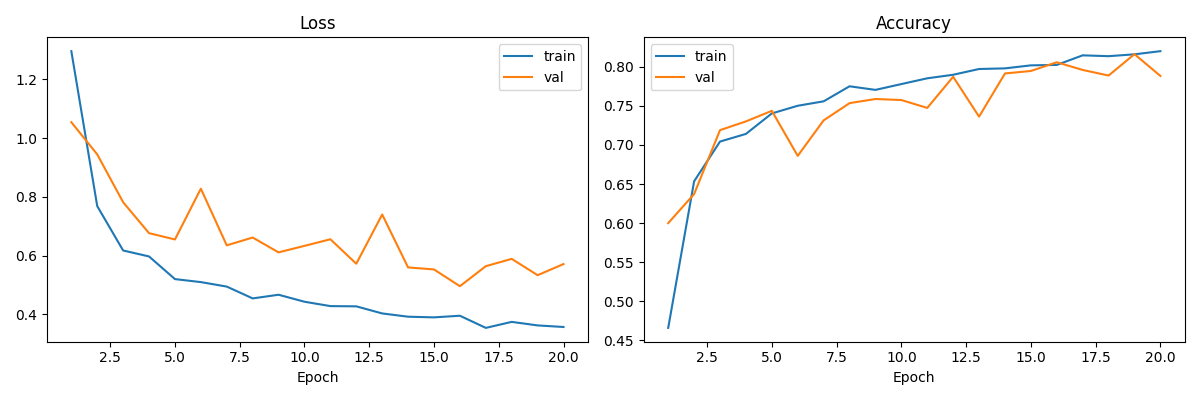

In [44]:
display(Image("vgg16_loss_acc.png"))

## NEW MODELS (convnext_tiny, vit_b_16, mobilevit_s)

###convnext_tiny

In [45]:
# convnext_tiny
!python3 src/train_all_crops.py \
  --data_dir /content/data/disease_data \
  --model convnext_tiny \
  --epochs 20 \
  --batch_size 32 \
  --lr 1e-4 \
  --weight_decay 1e-2 \
  --pretrained

→ Classes (22): ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf_miner', 'Cashew_red_rust', 'Cassava_bacterial_blight', 'Cassava_brown_spot', 'Cassava_green_mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall_armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf_beetle', 'Maize_leaf_blight', 'Maize_leaf_spot', 'Maize_streak_virus', 'Tomato_healthy', 'Tomato_leaf_blight', 'Tomato_leaf_curl', 'Tomato_septoria_leaf_spot', 'Tomato_verticulium_wilt']
Epoch 1/20  Train 0.7965/0.6579  Val   0.6475/0.7434
Epoch 2/20  Train 0.3809/0.8023  Val   0.4327/0.8309
Epoch 3/20  Train 0.3250/0.8288  Val   0.4128/0.8439
Epoch 4/20  Train 0.3118/0.8414  Val   0.4662/0.8352
Epoch 5/20  Train 0.2825/0.8469  Val   0.3870/0.8551
Epoch 6/20  Train 0.2625/0.8593  Val   0.3475/0.8729
Epoch 7/20  Train 0.2637/0.8656  Val   0.4428/0.8463
Epoch 8/20  Train 0.2402/0.8687  Val   0.4118/0.8458
Epoch 9/20  Train 0.2276/0.8755  Val   0.4146/0.8479
Epoch 10/20  Train 0.2198/0.8828  Val   

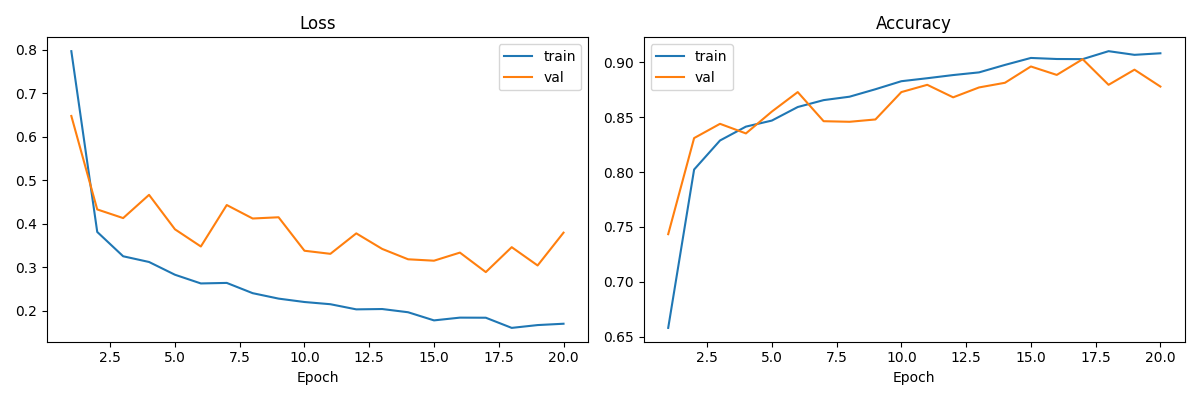

In [46]:
display(Image("convnext_tiny_loss_acc.png"))

###vit_b_16

In [47]:
# vit_b_16
!python3 src/train_all_crops.py \
  --data_dir /content/data/disease_data \
  --model vit_b_16 \
  --epochs 20 \
  --batch_size 32 \
  --lr 1e-4 \
  --weight_decay 1e-2 \
  --pretrained

→ Classes (22): ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf_miner', 'Cashew_red_rust', 'Cassava_bacterial_blight', 'Cassava_brown_spot', 'Cassava_green_mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall_armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf_beetle', 'Maize_leaf_blight', 'Maize_leaf_spot', 'Maize_streak_virus', 'Tomato_healthy', 'Tomato_leaf_blight', 'Tomato_leaf_curl', 'Tomato_septoria_leaf_spot', 'Tomato_verticulium_wilt']
Epoch 1/20  Train 0.6956/0.6844  Val   0.6304/0.7513
Epoch 2/20  Train 0.4440/0.7811  Val   0.5437/0.7864
Epoch 3/20  Train 0.4139/0.7937  Val   0.6552/0.7519
Epoch 4/20  Train 0.3665/0.8086  Val   0.5020/0.8094
Epoch 5/20  Train 0.3364/0.8247  Val   0.5442/0.7925
Epoch 6/20  Train 0.3424/0.8237  Val   0.5857/0.7874
Epoch 7/20  Train 0.3234/0.8330  Val   0.4443/0.8307
Epoch 8/20  Train 0.3135/0.8362  Val   0.5155/0.8118
Epoch 9/20  Train 0.3012/0.8405  Val   0.4356/0.8363
Epoch 10/20  Train 0.2916/0.8481  Val   

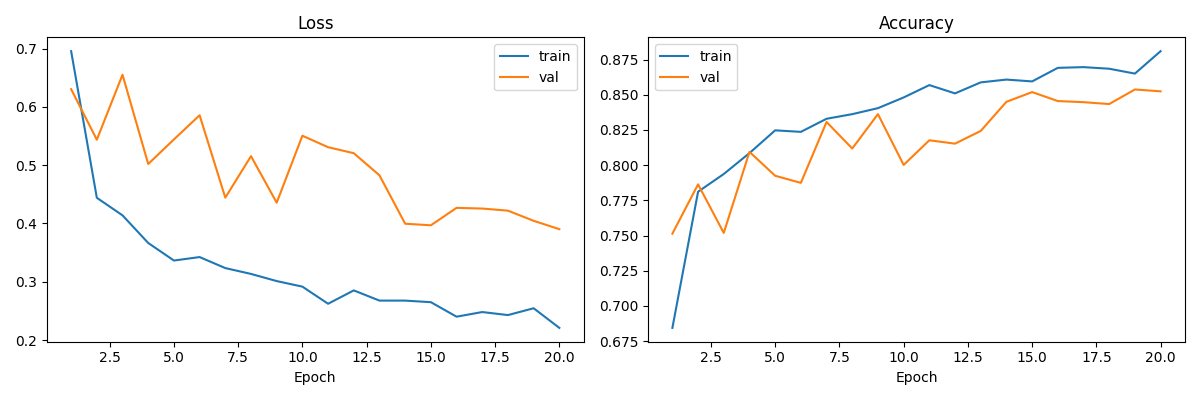

In [48]:
display(Image("vit_b_16_loss_acc.png"))

###mobilevit_s

In [49]:
# mobilevit_s
!python3 src/train_all_crops.py \
  --data_dir /content/data/disease_data \
  --model mobilevit_s \
  --epochs 20 \
  --batch_size 32 \
  --lr 1e-4 \
  --weight_decay 1e-2 \
  --pretrained

→ Classes (22): ['Cashew_anthracnose', 'Cashew_gumosis', 'Cashew_healthy', 'Cashew_leaf_miner', 'Cashew_red_rust', 'Cassava_bacterial_blight', 'Cassava_brown_spot', 'Cassava_green_mite', 'Cassava_healthy', 'Cassava_mosaic', 'Maize_fall_armyworm', 'Maize_grasshoper', 'Maize_healthy', 'Maize_leaf_beetle', 'Maize_leaf_blight', 'Maize_leaf_spot', 'Maize_streak_virus', 'Tomato_healthy', 'Tomato_leaf_blight', 'Tomato_leaf_curl', 'Tomato_septoria_leaf_spot', 'Tomato_verticulium_wilt']
Epoch 1/20  Train 1.6426/0.4072  Val   1.5868/0.5117
Epoch 2/20  Train 0.7307/0.6606  Val   0.9608/0.6433
Epoch 3/20  Train 0.5434/0.7306  Val   0.7397/0.7179
Epoch 4/20  Train 0.4688/0.7613  Val   0.6460/0.7399
Epoch 5/20  Train 0.4248/0.7780  Val   0.5867/0.7641
Epoch 6/20  Train 0.3851/0.7995  Val   0.5458/0.7792
Epoch 7/20  Train 0.3670/0.8042  Val   0.5152/0.7959
Epoch 8/20  Train 0.3458/0.8127  Val   0.5348/0.7919
Epoch 9/20  Train 0.3363/0.8234  Val   0.4998/0.8071
Epoch 10/20  Train 0.3165/0.8355  Val   

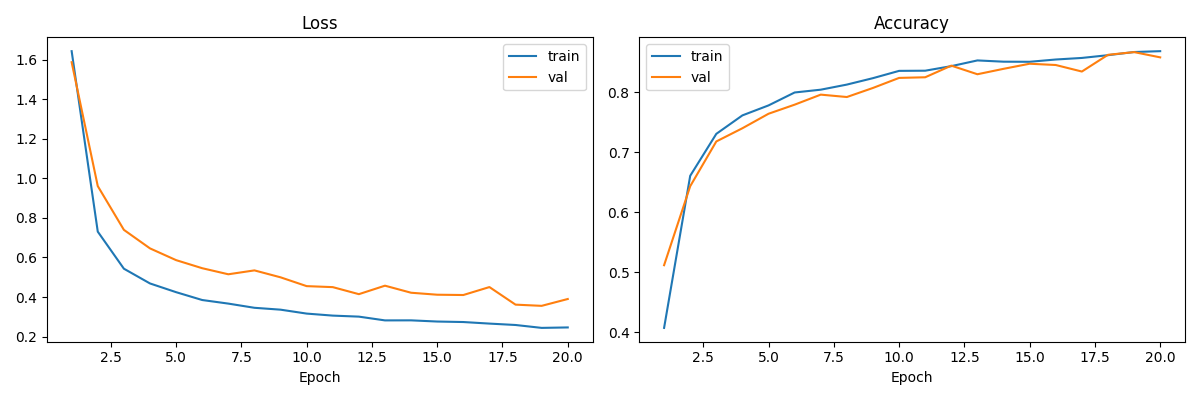

In [50]:
display(Image("mobilevit_s_loss_acc.png"))

## Evaluation

In [64]:
%cd /content/crop_detection_thesis
!python3 -m src.eval_all_crops --data_dir /content/data/disease_data --batch_size 32

/content/crop_detection_thesis
→ Using data root: /content/data/disease_data
→ Loaded test set: 3802 images, 22 classes

=== Evaluating alexnet ===
Accuracy: 0.7546

                           precision    recall  f1-score   support

       Cashew_anthracnose     0.8787    0.8077    0.8417       260
           Cashew_gumosis     0.8571    1.0000    0.9231        60
           Cashew_healthy     0.8670    0.9806    0.9203       206
        Cashew_leaf_miner     0.8950    0.9423    0.9180       208
          Cashew_red_rust     0.9837    0.9565    0.9699       253
 Cassava_bacterial_blight     0.9097    0.6412    0.7522       393
       Cassava_brown_spot     0.6855    0.8700    0.7668       223
       Cassava_green_mite     0.8393    0.9216    0.8785       153
          Cassava_healthy     0.8762    0.9833    0.9267       180
           Cassava_mosaic     0.8856    0.9780    0.9295       182
      Maize_fall_armyworm     0.8298    0.8864    0.8571        44
         Maize_grasshoper    

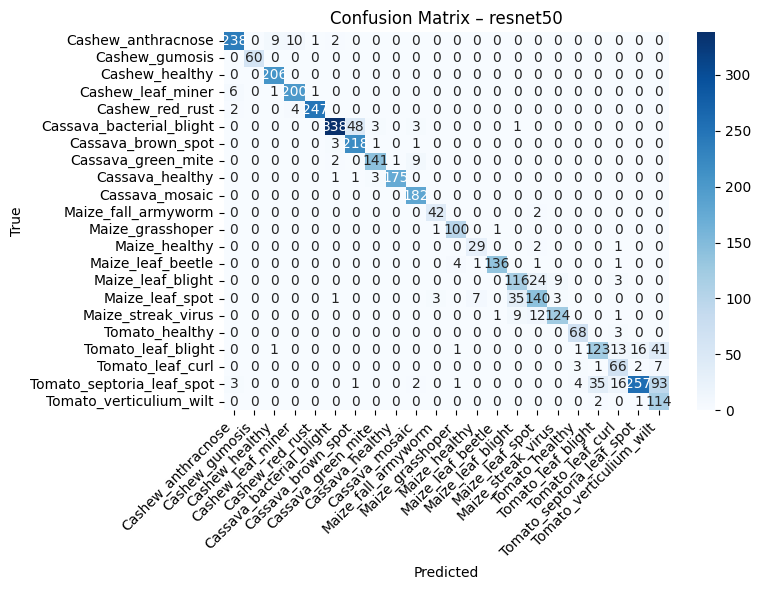

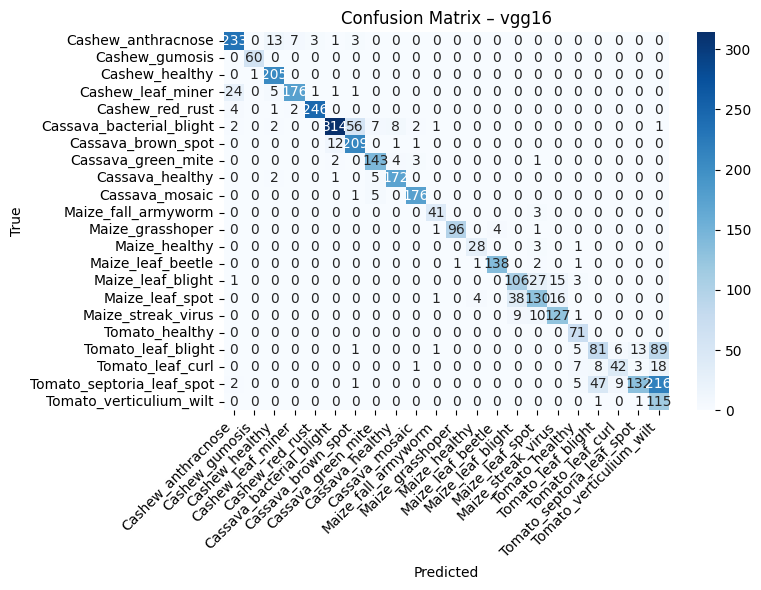

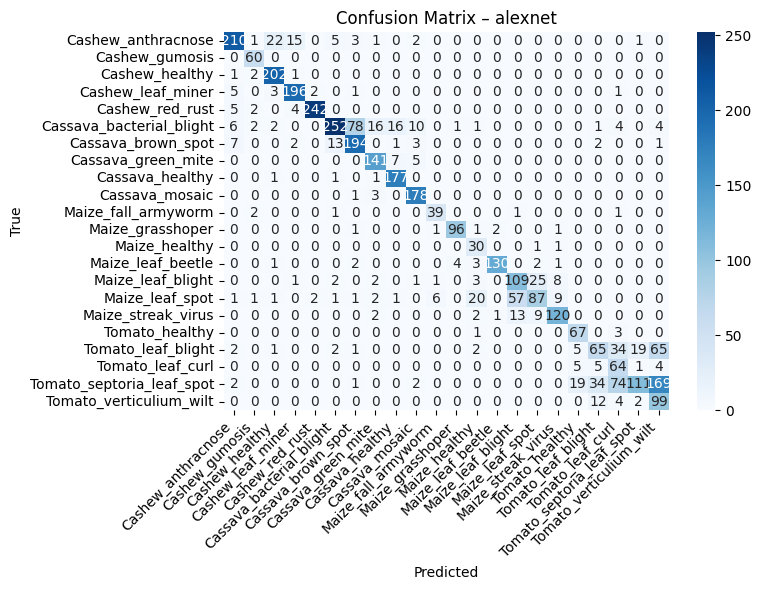

In [65]:
# Old models
display(Image("all_crop_cm_resnet50.png"))
display(Image("all_crop_cm_vgg16.png"))
display(Image("all_crop_cm_alexnet.png"))

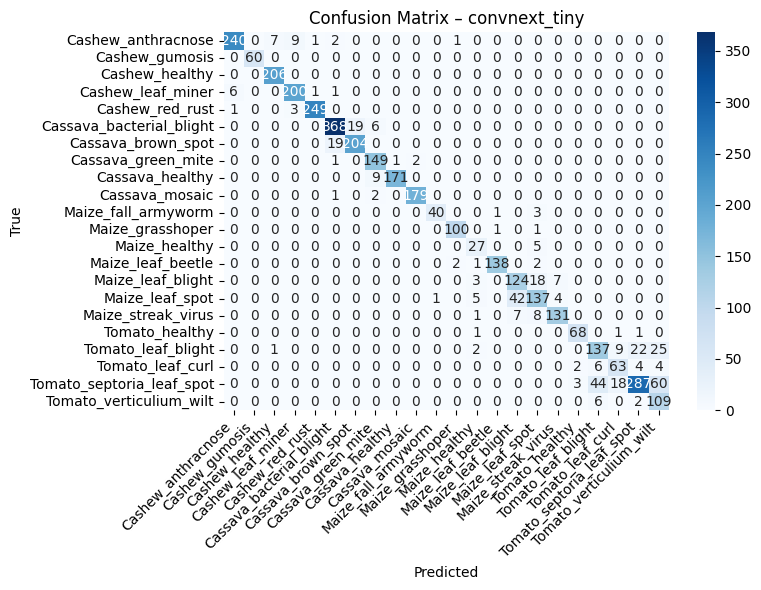

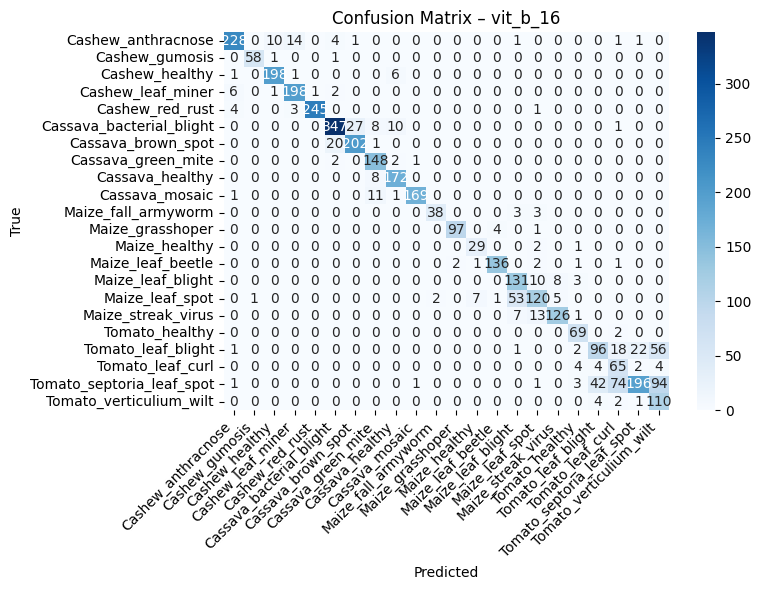

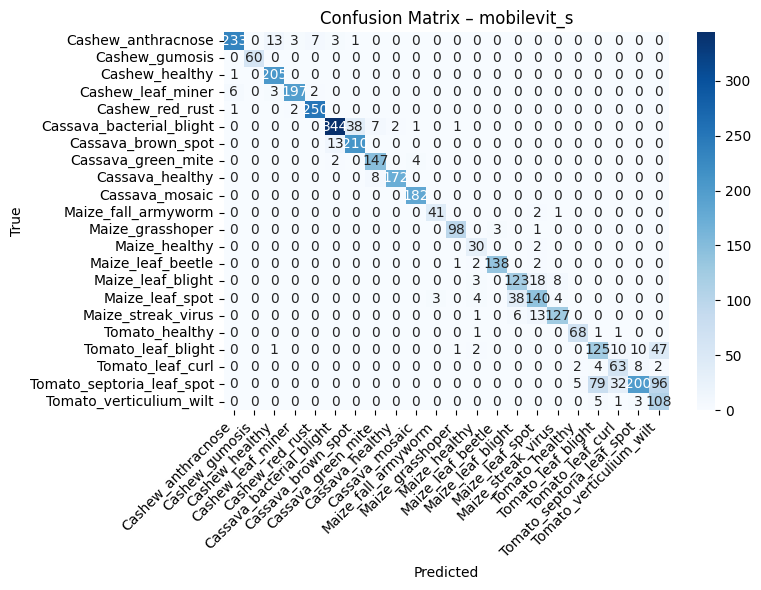

In [66]:
# New models
display(Image("all_crop_cm_convnext_tiny.png"))
display(Image("all_crop_cm_vit_b_16.png"))
display(Image("all_crop_cm_mobilevit_s.png"))